# baseline
In this experiment, we will create two baseline machine learning models to predict the values, providing a foundation for future iterations.
Now that we have everything ready, we will export the dataset.

In [1]:
import os
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords, names
import nltk
from nltk import ne_chunk, pos_tag
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
from matplotlib.colors import LinearSegmentedColormap
from wordcloud import WordCloud
from transformers import BertTokenizer, BertModel
import nltk
import torch
import re
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix , classification_report

# Download the stopwords if you haven't already
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('names')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('averaged_perceptron_tagger_eng')


# Custom imports
from helper.helper_eda import (proportion_balance_classes, extractions_text_description, histogram_bins,
                                plot_distribution_tokens_per_word, dimensionality_reduction_chart_tsne,
                               components_pca_3d_chart)


# ml versioning control
import dagshub
import mlflow
dagshub.init(repo_owner='auszed', repo_name='Experiments_fake_news', mlflow=True)

# traking experiments
os.environ['MLFLOW_TRACKING_USERNAME'] = 'auszed'
os.environ['MLFLOW_TRACKING_PASSWORD'] = '4390ce1796189f46f62a5e643463dcaffede3ebf'
os.environ['MLFLOW_TRACKING_URI'] = 'https://dagshub.com/auszed/Experiments_fake_news.mlflow'
  
# Enable code block
enable_code = False

# Inline plotting for Jupyter Notebooks
%matplotlib inline
custom_colors = ['#36CE8A', "#7436F5","#3736F4",   "#36AEF5", "#B336F5", "#f8165e", "#36709A",  "#3672F5", "#7ACE5D"]
gradient_colors = [ "#36CE8A", '#7436F5']
color_palette_custom  = sns.set_palette(custom_colors)
theme_color = sns.color_palette(color_palette_custom, 9)
cmap_theme = LinearSegmentedColormap.from_list('custom_colormap', gradient_colors)

# File paths
X_train = pd.read_csv("dataset/X_train.csv")
y_train = pd.read_csv("dataset/y_train.csv")
X_val = pd.read_csv("dataset/X_val.csv")
y_val = pd.read_csv("dataset/y_val.csv")
X_test = pd.read_csv("dataset/X_test.csv")
y_test = pd.read_csv("dataset/y_test.csv")

print(X_train.shape,y_train.shape )
print(X_val.shape,y_val.shape )
print(X_test.shape,y_test.shape )

theme_color

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hanns\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hanns\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package names to
[nltk_data]     C:\Users\hanns\AppData\Roaming\nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\hanns\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\hanns\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\hanns\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]

Accessing as auszed

Initialized MLflow to track repo "auszed/Experiments_fake_news"

Repository auszed/Experiments_fake_news initialized!

(26759, 39) (26759, 1)
(5734, 39) (5734, 1)
(5735, 39) (5735, 1)


[(0.21176470588235294, 0.807843137254902, 0.5411764705882353),
 (0.4549019607843137, 0.21176470588235294, 0.9607843137254902),
 (0.21568627450980393, 0.21176470588235294, 0.9568627450980393),
 (0.21176470588235294, 0.6823529411764706, 0.9607843137254902),
 (0.7019607843137254, 0.21176470588235294, 0.9607843137254902),
 (0.9725490196078431, 0.08627450980392157, 0.3686274509803922),
 (0.21176470588235294, 0.4392156862745098, 0.6039215686274509),
 (0.21176470588235294, 0.4470588235294118, 0.9607843137254902),
 (0.47843137254901963, 0.807843137254902, 0.36470588235294116)]

In [2]:
X_train.drop(["title", "text"], axis=1, inplace=True)
X_val.drop(["title", "text"], axis=1, inplace=True)
X_test.drop(["title", "text"], axis=1, inplace=True)

X_train.sample(5)

,subject,date,is_twitter_handle,is_reuters,title_count_each_word,title_count_unique_word,title_count_punctuations,title_count_words_title,title_count_stopwords,title_mean_word_len,...,text_new_line,text_new_small_space,text_new_medium_space,text_new_big_space,text_uppercase_words,text_question_mark,text_exclamation_mark,text_word_unique_percent,text_punctuations_percent,title_text_join
19873,US_News,2016-01-31,False,False,14,14,1,7,3,5.071429,...,0,0,0,0,209,0,1,70.661157,8.677686,Episode 120 SUNDAY WIRE: ‘Crisis of Liberty...
18006,politicsNews,2017-04-07,False,True,9,9,0,1,3,5.777778,...,0,0,0,0,28,0,0,64.492754,11.594203,Syrian presidency vows to step up campaign aga...
8344,News,2016-06-18,False,False,16,16,0,14,5,5.125000,...,0,0,0,0,97,1,1,57.956449,9.045226,Florida GOPer Wants LGBT Flag Removed Because...
16153,worldnews,2017-10-28,False,True,12,12,4,2,2,5.583333,...,0,0,0,0,94,0,0,59.000000,9.000000,Myanmar corrects state media report on U.N. 'a...
9216,worldnews,2017-10-27,False,True,11,11,1,1,1,6.818182,...,0,0,0,0,120,0,0,51.907357,9.945504,Australian court rules deputy PM ineligible fo...


We will remove some columns that we think couldn’t impact the results of the model:

- date
- title_count_unique_word
- title_count_punctuations
- title_count_words_title
- title_count_stopwords
- title_mean_word_len
- title_total_length
- title_new_line
- title_new_small_space
- title_new_medium_space
- title_new_big_space
- title_uppercase_words
- title_question_mark
- title_exclamation_mark
- title_word_unique_percent
- title_punctuations_percent
- text_count_unique_word
- text_count_punctuations
- text_count_words_title
- text_count_stopwords
- text_mean_word_len
- text_total_length
- text_new_line
- text_new_small_space
- text_new_medium_space
- text_new_big_space
- text_uppercase_words
- text_question_mark
- text_exclamation_mark
- text_word_unique_percent
- text_punctuations_percent


In [3]:
X_train = X_train[['subject', 'is_twitter_handle', 'is_reuters', 'title_count_each_word', 'text_count_each_word', 'title_text_join']]
X_val = X_val[['subject', 'is_twitter_handle', 'is_reuters', 'title_count_each_word', 'text_count_each_word', 'title_text_join']]
X_test = X_test[['subject', 'is_twitter_handle', 'is_reuters', 'title_count_each_word', 'text_count_each_word', 'title_text_join']]
X_train.sample()

,subject,is_twitter_handle,is_reuters,title_count_each_word,text_count_each_word,title_text_join
3676,politicsNews,False,True,11,633,Iran deal's foes in U.S. Congress may be its u...


# Metrics
We will use the F1 score as the primary performance metric for both machine learning algorithms and deep learning models. This allows us to compare their performance consistently.

# Preprocess pipeline
We will start with a Naive bayes model 

In [4]:
# Define transformations for each column
text_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words='english'))  
])
numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")), 
    ("scaler", StandardScaler())  
])
categorical_pipeline = Pipeline([
    ("onehot", OneHotEncoder(sparse_output=False, handle_unknown='ignore'))  
])
binary_pipeline = Pipeline([
    ("binary_to_int", FunctionTransformer(lambda x: x.astype(int)))  # Convert True/False to 1/0
])

preprocessor = ColumnTransformer(
    transformers=[
        ("text", text_pipeline, "title_text_join"),
        ("numeric", numeric_pipeline, ["title_count_each_word", "text_count_each_word"]),
        ("categorical", categorical_pipeline, ["subject"]),
        ("binary", binary_pipeline, ["is_twitter_handle", "is_reuters"]) 
    ]
)
preprocessor

ColumnTransformer(transformers=[('text',
                                 Pipeline(steps=[('tfidf',
                                                  TfidfVectorizer(stop_words='english'))]),
                                 'title_text_join'),
                                ('numeric',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['title_count_each_word',
                                  'text_count_each_word']),
                                ('categorical',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['subject']),
                                ('binary',
                                 Pipeline(steps=[('binary_to_int',
                                                  FunctionTransformer(func=<function <lambda> at 0x000001F2E988D6C0>))]),
                                 ['is_twitter_handle', 'is_reuters'])])

# Models
We will start we the baseline models so we can see how the model performs in this environment.

## Experiment 1
We will use a logistic regression and a random forest for the baseline model so we can see how it performs.

C:\Users\hanns\anaconda3\envs\nlp\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2611
           1       1.00      1.00      1.00      3123

    accuracy                           1.00      5734
   macro avg       1.00      1.00      1.00      5734
weighted avg       1.00      1.00      1.00      5734



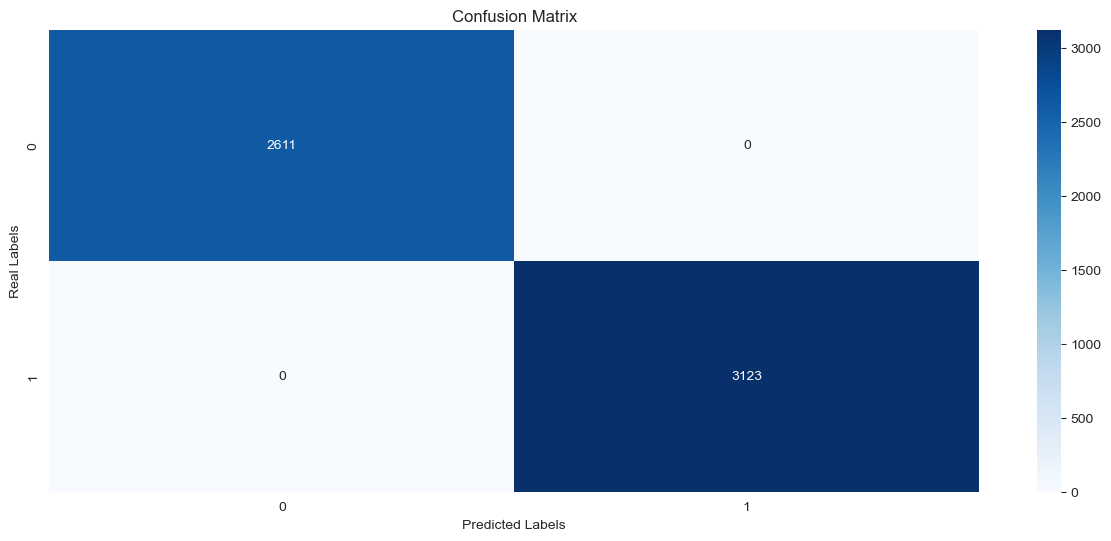

2025/01/13 09:41:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Experiment logged successfully!
🏃 View run Logistic Regression Experiment at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0/runs/5b8972dfac7c44609f6b5eca7f6dde76
🧪 View experiment at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0


<Figure size 640x480 with 0 Axes>

In [5]:
model_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression()) 
])


model_pipeline.fit(X_train, y_train)
y_pred = model_pipeline.predict(X_val)
report = classification_report(y_val, y_pred, output_dict=True)
cm = confusion_matrix(y_val, y_pred)
print(classification_report(y_val, y_pred))


mlflow.set_experiment("Fake news comments")
with mlflow.start_run(run_name="Logistic Regression Experiment"):
    # Log parameters
    mlflow.log_param("model", "LogisticRegression")
    mlflow.log_param("preprocessor", "Custom Preprocessor")
    mlflow.log_param("data_split", "Train/Validation/Test")
    
    # Log confusion matrix values
    for i, row in enumerate(cm):
        for j, value in enumerate(row):
            mlflow.log_metric(f"cm_{i}_{j}", value)  # Example: cm_0_0 for true negatives
    
    # Log metrics from classification report
    for metric, value in report["weighted avg"].items():
        mlflow.log_metric(f"weighted_{metric}", value)
    mlflow.log_metric("accuracy", report["accuracy"])
    
    # Log overall metrics
    total_samples = len(y_val)
    correct_predictions = sum(cm[i][i] for i in range(len(cm)))  # Diagonal sum
    incorrect_predictions = total_samples - correct_predictions
    mlflow.log_metric("total_samples", total_samples)
    mlflow.log_metric("correct_predictions", correct_predictions)
    mlflow.log_metric("incorrect_predictions", incorrect_predictions)
    
    # Log the confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(15, 6))
    sns.heatmap(cm, annot=True, fmt='', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('Real Labels')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Save the confusion matrix as an artifact
    cm_file = "confusion_matrix.png"
    plt.savefig(cm_file)
    mlflow.log_artifact(cm_file)

    # Log the model
    mlflow.sklearn.log_model(model_pipeline, "model_pipeline")

    print("Experiment logged successfully!")
    

Here we had a perfect score, so we need to give it a look whats happening.

C:\Users\hanns\anaconda3\envs\nlp\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2611
           1       0.99      1.00      1.00      3123

    accuracy                           1.00      5734
   macro avg       1.00      1.00      1.00      5734
weighted avg       1.00      1.00      1.00      5734



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer(stop_words='english'))]),
                                                  'title_text_join'),
                                                 ('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['title_count_each_word',
                                                   'text_count_each_word']),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['subject']),
                                                 ('binary',
                                                  Pipeline(steps=[('binary_to_int',
                                                                   FunctionTransformer(func=<function <lambda> at 0x000001F2E988D6C0>))]),
                                                  ['is_twitter_handle',
                                                   'is_reuters'])])),
                ('classifier', RandomForestClassifier(n_estimators=300))])

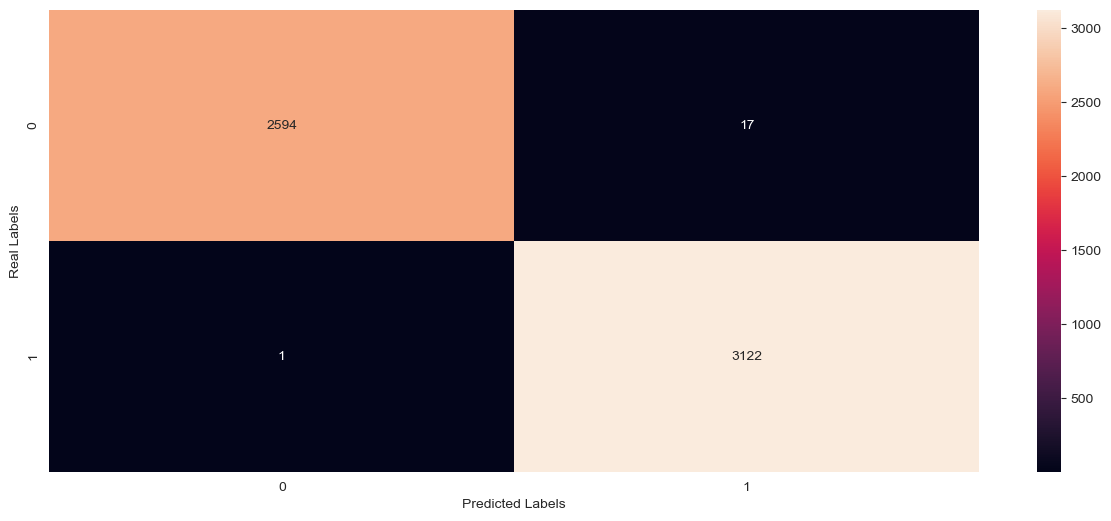

In [6]:
model_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(n_estimators=300))  
])

model_pipeline.fit(X_train, y_train)
y_pred = model_pipeline.predict(X_val)
print(classification_report(y_val, y_pred))

# confusion_matrix 
plt.figure(figsize = (15,6))
sns.heatmap(confusion_matrix(y_val,y_pred), annot=True, fmt='')
plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')
model_pipeline

In this case kind of happens the same, so we need to check the data again.
## Experiment 2, Heuristic

after looking the dataset we will try to take out some features from the datasets so it can generalize better,
because when we do the EDA seems that some features can had a lot of predictability.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2611
           1       1.00      1.00      1.00      3123

    accuracy                           1.00      5734
   macro avg       1.00      1.00      1.00      5734
weighted avg       1.00      1.00      1.00      5734



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer(stop_words='english'))]),
                                                  'title_text_join'),
                                                 ('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['title_count_each_word',
                                                   'text_count_each_word']),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['subject']),
                                                 ('binary',
                                                  Pipeline(steps=[('binary_to_int',
                                                                   FunctionTransformer(func=<function <lambda> at 0x000001F2E988D6C0>))]),
                                                  ['is_twitter_handle',
                                                   'is_reuters'])])),
                ('classifier', RandomForestClassifier(n_estimators=300))])

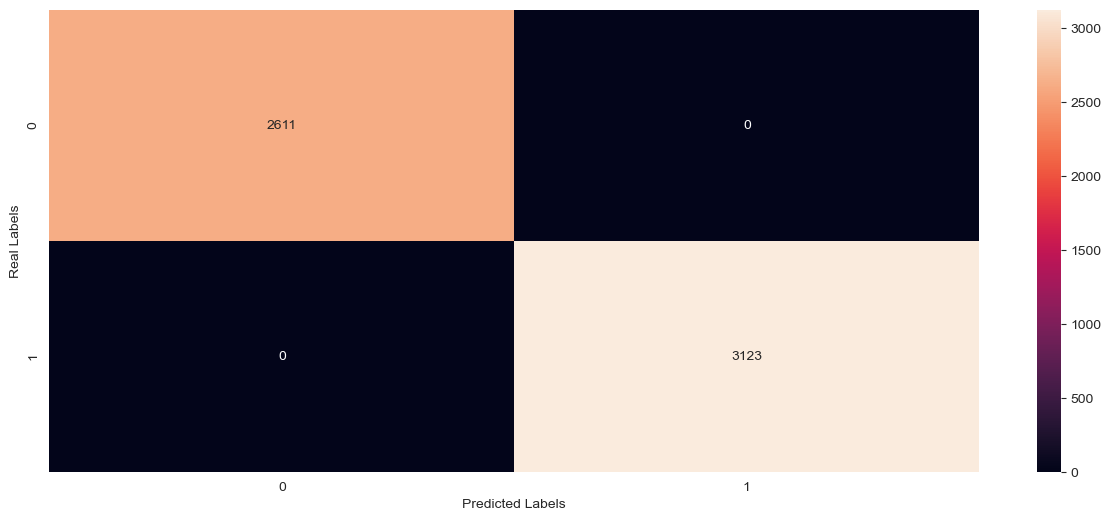

In [7]:
# List append
def prediction_heuristic(column):
    prediction_X = []
    for subject in column:
        if subject in ["worldnews", "politicsNews"]:
            prediction_X.append(1)
        else:
            prediction_X.append(0)
            
    return prediction_X

y_pred = prediction_heuristic(X_val["subject"])
print(classification_report(y_val, y_pred))

# confusion_matrix 
plt.figure(figsize = (15,6))
sns.heatmap(confusion_matrix(y_val,y_pred), annot=True, fmt='')
plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')
model_pipeline

Just by using the heuristic we can detect the correct class,
so we will try
to take out those features that can impact the results for now we will take just the subject to see
if we got a more accrued result.

## Experiment 3

In [8]:
X_train = pd.read_csv("dataset/X_train.csv")
X_val = pd.read_csv("dataset/X_val.csv")
X_test = pd.read_csv("dataset/X_test.csv")

X_train =X_train.drop(columns= ["title", "text", "subject", "date", "title_new_line", "title_new_small_space", "title_new_medium_space", "title_new_big_space",
                                "text_new_line", "text_new_small_space", "text_new_medium_space", "text_new_big_space"])
X_val = X_val.drop(columns= ["title", "text", "subject", "date", "title_new_line", "title_new_small_space", "title_new_medium_space", "title_new_big_space",
                             "text_new_line", "text_new_small_space", "text_new_medium_space", "text_new_big_space"])
X_test = X_test.drop(columns= ["title", "text", "subject", "date", "title_new_line", "title_new_small_space", "title_new_medium_space", "title_new_big_space",
                               "text_new_line", "text_new_small_space", "text_new_medium_space", "text_new_big_space"])

X_train.nunique()

is_twitter_handle                 2
is_reuters                        2
title_count_each_word            40
title_count_unique_word          38
title_count_punctuations          9
title_count_words_title          33
title_count_stopwords            19
title_mean_word_len             746
title_total_length              202
title_uppercase_words           106
title_question_mark               4
title_exclamation_mark            4
title_word_unique_percent        77
title_punctuations_percent      129
text_count_each_word           1480
text_count_unique_word          842
text_count_punctuations         306
text_count_words_title          382
text_count_stopwords            757
text_mean_word_len            20585
text_total_length              6144
text_uppercase_words            548
text_question_mark               32
text_exclamation_mark            24
text_word_unique_percent      13672
text_punctuations_percent     10079
title_text_join               26759
dtype: int64

Now we preprocess the pipeline again.

In [9]:
X_train.dtypes

is_twitter_handle                bool
is_reuters                       bool
title_count_each_word           int64
title_count_unique_word         int64
title_count_punctuations        int64
title_count_words_title         int64
title_count_stopwords           int64
title_mean_word_len           float64
title_total_length              int64
title_uppercase_words           int64
title_question_mark             int64
title_exclamation_mark          int64
title_word_unique_percent     float64
title_punctuations_percent    float64
text_count_each_word            int64
text_count_unique_word          int64
text_count_punctuations         int64
text_count_words_title          int64
text_count_stopwords            int64
text_mean_word_len            float64
text_total_length               int64
text_uppercase_words            int64
text_question_mark              int64
text_exclamation_mark           int64
text_word_unique_percent      float64
text_punctuations_percent     float64
title_text_j

In [10]:
numeric_pipeline_values = ["title_count_each_word", "title_count_unique_word", "title_count_punctuations", "title_count_words_title", "title_count_stopwords", "title_mean_word_len", "title_total_length", "title_uppercase_words", "title_question_mark", "title_exclamation_mark", "title_word_unique_percent", "title_punctuations_percent", "text_count_each_word", "text_count_unique_word", "text_count_punctuations", "text_count_words_title", "text_count_stopwords", "text_mean_word_len", "text_total_length", "text_uppercase_words", "text_question_mark", "text_exclamation_mark", "text_word_unique_percent", "text_punctuations_percent"]


preprocessor_2 = ColumnTransformer(
    transformers=[
        ("text", text_pipeline, "title_text_join"),
        ("numeric", numeric_pipeline, numeric_pipeline_values),
        ("binary", binary_pipeline, ["is_twitter_handle", "is_reuters"]) 
    ]
)
preprocessor_2

ColumnTransformer(transformers=[('text',
                                 Pipeline(steps=[('tfidf',
                                                  TfidfVectorizer(stop_words='english'))]),
                                 'title_text_join'),
                                ('numeric',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['title_count_each_word',
                                  'title_count_unique_word',
                                  'title_count_punctuations',
                                  'title_count_words_title',
                                  'title_count_stopwords',
                                  'title_mean_...
                                  'text_count_words_title',
                                  'text_count_stopwords', 'text_mean_word_len',
                                  'text_total_length', 'text_uppercase_words',
                                  'text_question_mark', 'text_exclamation_mark',
                                  'text_word_unique_percent',
                                  'text_punctuations_percent']),
                                ('binary',
                                 Pipeline(steps=[('binary_to_int',
                                                  FunctionTransformer(func=<function <lambda> at 0x000001F2E988D6C0>))]),
                                 ['is_twitter_handle', 'is_reuters'])])

C:\Users\hanns\anaconda3\envs\nlp\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2611
           1       1.00      1.00      1.00      3123

    accuracy                           1.00      5734
   macro avg       1.00      1.00      1.00      5734
weighted avg       1.00      1.00      1.00      5734



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer(stop_words='english'))]),
                                                  'title_text_join'),
                                                 ('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['title_count_each_word',
                                                   'title_count_unique_word',
                                                   'title_count_punctuations',
                                                   'title_count_words_title',
                                                   'tit...
                                                   'text_mean_word_len',
                                                   'text_total_length',
                                                   'text_uppercase_words',
                                                   'text_question_mark',
                                                   'text_exclamation_mark',
                                                   'text_word_unique_percent',
                                                   'text_punctuations_percent']),
                                                 ('binary',
                                                  Pipeline(steps=[('binary_to_int',
                                                                   FunctionTransformer(func=<function <lambda> at 0x000001F2E988D6C0>))]),
                                                  ['is_twitter_handle',
                                                   'is_reuters'])])),
                ('classifier', LogisticRegression())])

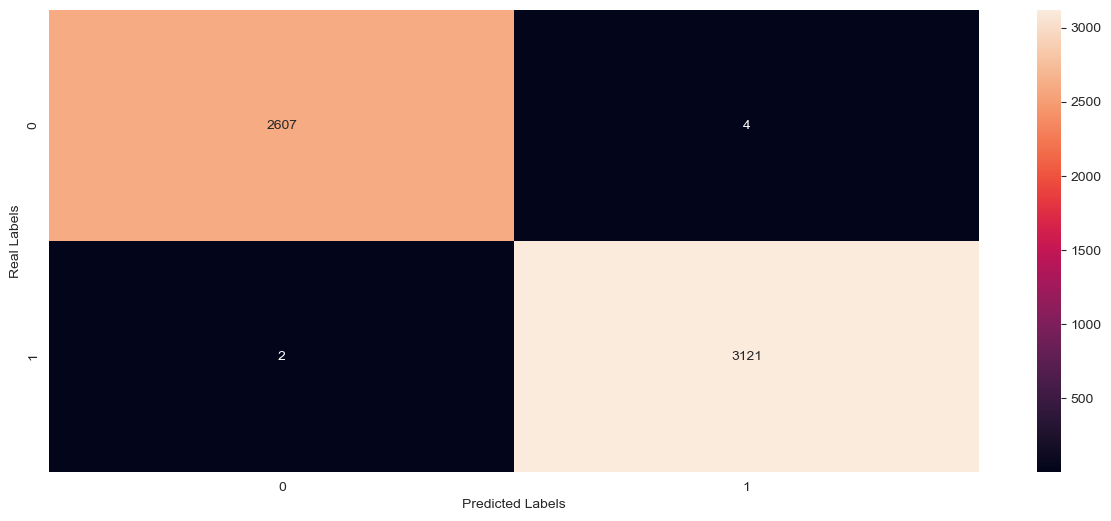

In [11]:
model_pipeline = Pipeline([
    ("preprocessor", preprocessor_2),
    ("classifier", LogisticRegression()) 
])

model_pipeline.fit(X_train, y_train)
y_pred = model_pipeline.predict(X_val)
print(classification_report(y_val, y_pred))

# confusion_matrix 
plt.figure(figsize = (15,6))
sns.heatmap(confusion_matrix(y_val,y_pred), annot=True, fmt='' )
plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')
model_pipeline

Seems that the model still predicting the same,
so we will try
to take out the Reuters and twitter handle to see if we could handle a correct performance for the baseline.

# Experiment 4

Now we will try to reduce the number of features and see how they perform.

In [12]:
X_train =X_train.drop(columns= ["is_twitter_handle", "is_reuters", ])
X_val = X_val.drop(columns= ["is_twitter_handle", "is_reuters", ])
X_test = X_test.drop(columns= ["is_twitter_handle", "is_reuters", ])

preprocessor_3 = ColumnTransformer(
    transformers=[
        ("text", text_pipeline, "title_text_join"),
        ("numeric", numeric_pipeline, numeric_pipeline_values)
    ]
)
preprocessor_3

ColumnTransformer(transformers=[('text',
                                 Pipeline(steps=[('tfidf',
                                                  TfidfVectorizer(stop_words='english'))]),
                                 'title_text_join'),
                                ('numeric',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['title_count_each_word',
                                  'title_count_unique_word',
                                  'title_count_punctuations',
                                  'title_count_words_title',
                                  'title_count_stopwords',
                                  'title_mean_...
                                  'title_exclamation_mark',
                                  'title_word_unique_percent',
                                  'title_punctuations_percent',
                                  'text_count_each_word',
                                  'text_count_unique_word',
                                  'text_count_punctuations',
                                  'text_count_words_title',
                                  'text_count_stopwords', 'text_mean_word_len',
                                  'text_total_length', 'text_uppercase_words',
                                  'text_question_mark', 'text_exclamation_mark',
                                  'text_word_unique_percent',
                                  'text_punctuations_percent'])])

C:\Users\hanns\anaconda3\envs\nlp\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2611
           1       1.00      1.00      1.00      3123

    accuracy                           1.00      5734
   macro avg       1.00      1.00      1.00      5734
weighted avg       1.00      1.00      1.00      5734



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer(stop_words='english'))]),
                                                  'title_text_join'),
                                                 ('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['title_count_each_word',
                                                   'title_count_unique_word',
                                                   'title_count_punctuations',
                                                   'title_count_words_title',
                                                   'tit...
                                                   'title_punctuations_percent',
                                                   'text_count_each_word',
                                                   'text_count_unique_word',
                                                   'text_count_punctuations',
                                                   'text_count_words_title',
                                                   'text_count_stopwords',
                                                   'text_mean_word_len',
                                                   'text_total_length',
                                                   'text_uppercase_words',
                                                   'text_question_mark',
                                                   'text_exclamation_mark',
                                                   'text_word_unique_percent',
                                                   'text_punctuations_percent'])])),
                ('classifier', LogisticRegression())])

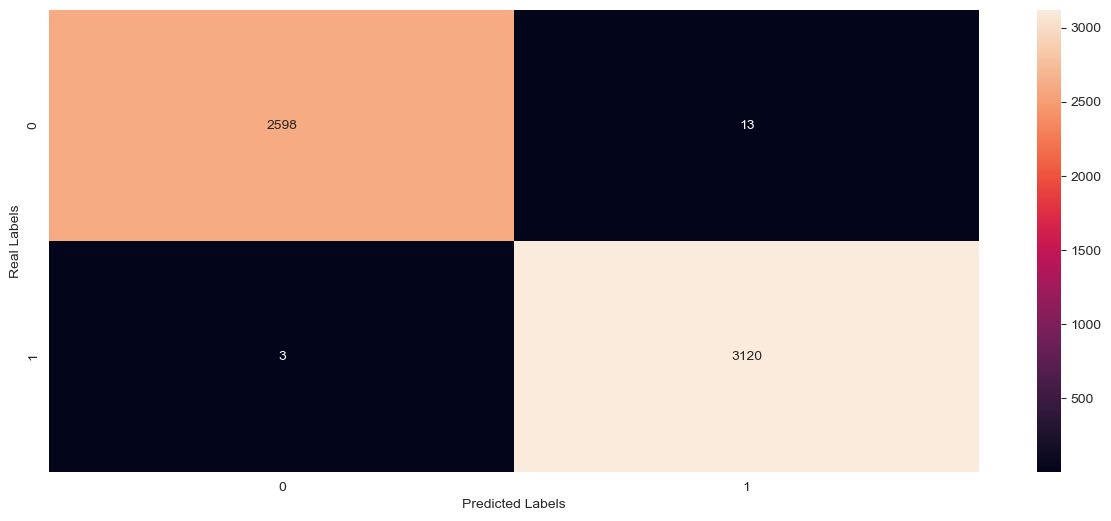

In [13]:
model_pipeline = Pipeline([
    ("preprocessor", preprocessor_3),
    ("classifier", LogisticRegression()) 
])

model_pipeline.fit(X_train, y_train)
y_pred = model_pipeline.predict(X_val)
print(classification_report(y_val, y_pred))

# confusion_matrix 
plt.figure(figsize = (15,6))
sns.heatmap(confusion_matrix(y_val,y_pred), annot=True, fmt='' )
plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')
model_pipeline

# Experiment 5
Seems that i still got the same results, i will take out also the Reuters and twitter words from the final dataset.

In [14]:
def clean_text(text):
    """Delete the Reuters and the twitter handle"""
    list_words = []
    text = re.sub(r'\bReuters\b', '', text, flags=re.IGNORECASE)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'VIDEO', '', text)
    text = re.sub(r'VIDEOS', '', text)
    text = re.sub(r'TWEETS', '', text)
    text = re.sub(r'IMAGE', '', text)
    text = re.sub(r'IMAGES', '', text)
    text = re.sub(r'AUDIO', '', text)
    #take out more then 2 spaces
    text = re.sub(r" {2,}"," ",text) 
    text = text.lower()  
    text = text.strip()
    
    tokens = word_tokenize(text)
    stopword_list = set(stopwords.words('english'))
    filtered_words = [word for word in tokens if word not in stopword_list]
    cleaned_text = ' '.join(filtered_words)
        
    return cleaned_text

X_train = X_train[['title_text_join']]
X_val = X_val[['title_text_join']]
X_test = X_test[['title_text_join']]

X_train["title_text_join"] = X_train['title_text_join'].apply(clean_text)
X_val["title_text_join"] = X_val['title_text_join'].apply(clean_text)
X_test["title_text_join"] = X_test['title_text_join'].apply(clean_text)

In [30]:
X_train['unique_words'] = X_train['title_text_join'].apply(  lambda x: list(set(str(x).split()))) 
X_val['unique_words'] = X_val['title_text_join'].apply(  lambda x: list(set(str(x).split())))
X_test['unique_words'] = X_test['title_text_join'].apply(  lambda x: list(set(str(x).split())))

unique_words_combined = set(
    word 
    for dataset in [X_train, X_val, X_test] 
    for row in dataset['unique_words'] 
    for word in row
)
unique_words_list = sorted(unique_words_combined)
len(unique_words_list)

206531

In [36]:
nlp = spacy.load("en_core_web_lg")

def find_matching_entities_in_chunks(text, chunk_size=100000):
    """Process long text in chunks for named entity recognition."""

    chunks = [text[i:i + chunk_size] for i in range(0, len(text), chunk_size)]
    all_entities = set()
    for chunk in chunks:
        doc = nlp(chunk)
        
        # Extract entities from the chunk
        gpe_entities = [ent.text for ent in doc.ents if ent.label_ == "GPE"]
        # org_entities = [ent.text for ent in doc.ents if ent.label_ == "ORG"]
        # person_entities = [ent.text for ent in doc.ents if ent.label_ == "PERSON"]
        # product_entities = [ent.text for ent in doc.ents if ent.label_ == "PRODUCT"]
        # event_entities = [ent.text for ent in doc.ents if ent.label_ == "EVENT"]
        # language_entities = [ent.text for ent in doc.ents if ent.label_ == "LANGUAGE"]

        # Combine all entities into a single set
        all_entities.update(
            gpe_entities 
            # org_entities + person_entities + product_entities + event_entities + language_entities
        )

    
    return list(all_entities)

# Example usage
text_unique_words_join = " ".join(unique_words_list)  # Join the unique words into a single string
result = find_matching_entities_in_chunks(text_unique_words_join)

print("Extracted Entities:", result)
len(result)

Extracted Entities: ['macronberlin', 'oct.1', 'roseville', 'anyway.carl', 'bradenton', 'karimov', 'lowell', 'tulum', 'warmingmiami warmingnew warmingsacrifice', 'york', 'spending.yes', 'petaling', "nonsense'moscow", 'foreverrepublicans', 'nairobi', 'spain', 'manila', 'luxemburg', 'nbcfakenews', 'livemost livemove livengood', 'emirate emirates', 'laothamatas', 'semisovereign', 'dublin dubois dubos', 'laguna', 'methuen', 'leavenworth', 'budgetsan', 'virgina virginia', 'tehran', 'danang', 'middletown', 'frankfort', 'minnesota', 'iraq.will iraq21st', 'terrorismbaghdad', 'passaic', 'tajikistan', 'tincher', 'sunbury', 'theironfront', 'militaryparis', 'knowsdonald', 'machine.then', 'tianjin', 'hunan', 'milbank', 'visaswashington visayas', 'donaldjtrump.com.massive', 'capetown', 'weaknesseswashington', 'daklak dakota', 'baden', 'waltham', 'lawrenceburg', 'n.h.', 'yucaipa', 'krasnoyarsk', 'trumpyou', 'billiken billin', 'tuskgothenburg', 'columbus', 'odisha', 'yuba', 'certificates.yes', 'scandal

1434

In [37]:
def replace_entities(text, entities):
    """Replace all entities in the text with an empty string."""
    for entity in entities:
        text = re.sub(rf"\b{re.escape(entity)}\b", "", text, flags=re.IGNORECASE)
    return text.strip()

# Function to process a column and log progress
def process_with_logging(df, column_name, entities, output_column):
    """Process text column with entity replacement and log every 100 rows."""
    cleaned_text = []
    for i, text in enumerate(df[column_name]):
        cleaned_text.append(replace_entities(text, entities))
        
        # Log progress every 100 rows
        if (i + 1) % 500 == 0:
            print(f"Processed {i + 1} rows.")
    
    # Assign the cleaned column to the dataframe
    df[output_column] = cleaned_text

# Process the datasets with logging
process_with_logging(X_train, "title_text_join", result, "title_text_cleaned")
process_with_logging(X_val, "title_text_join", result, "title_text_cleaned")
process_with_logging(X_test, "title_text_join", result, "title_text_cleaned")

Processed 500 rows.
Processed 1000 rows.
Processed 1500 rows.
Processed 2000 rows.
Processed 2500 rows.
Processed 3000 rows.
Processed 3500 rows.
Processed 4000 rows.
Processed 4500 rows.
Processed 5000 rows.
Processed 5500 rows.


In [42]:
process_with_logging(X_train, "title_text_join", result, "title_text_cleaned")
process_with_logging(X_val, "title_text_join", result, "title_text_cleaned")

Processed 500 rows.
Processed 1000 rows.
Processed 1500 rows.
Processed 2000 rows.
Processed 2500 rows.
Processed 3000 rows.
Processed 3500 rows.
Processed 4000 rows.
Processed 4500 rows.
Processed 5000 rows.
Processed 5500 rows.
Processed 6000 rows.
Processed 6500 rows.
Processed 7000 rows.
Processed 7500 rows.
Processed 8000 rows.
Processed 8500 rows.
Processed 9000 rows.
Processed 9500 rows.
Processed 10000 rows.
Processed 10500 rows.
Processed 11000 rows.
Processed 11500 rows.
Processed 12000 rows.
Processed 12500 rows.
Processed 13000 rows.
Processed 13500 rows.
Processed 14000 rows.
Processed 14500 rows.
Processed 15000 rows.
Processed 15500 rows.
Processed 16000 rows.
Processed 16500 rows.
Processed 17000 rows.
Processed 17500 rows.
Processed 18000 rows.
Processed 18500 rows.
Processed 19000 rows.
Processed 19500 rows.
Processed 20000 rows.
Processed 20500 rows.
Processed 21000 rows.
Processed 21500 rows.
Processed 22000 rows.
Processed 22500 rows.
Processed 23000 rows.
Processe

C:\Users\hanns\anaconda3\envs\nlp\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.98      0.97      0.97      2611
           1       0.97      0.98      0.98      3123

    accuracy                           0.98      5734
   macro avg       0.98      0.97      0.98      5734
weighted avg       0.98      0.98      0.98      5734



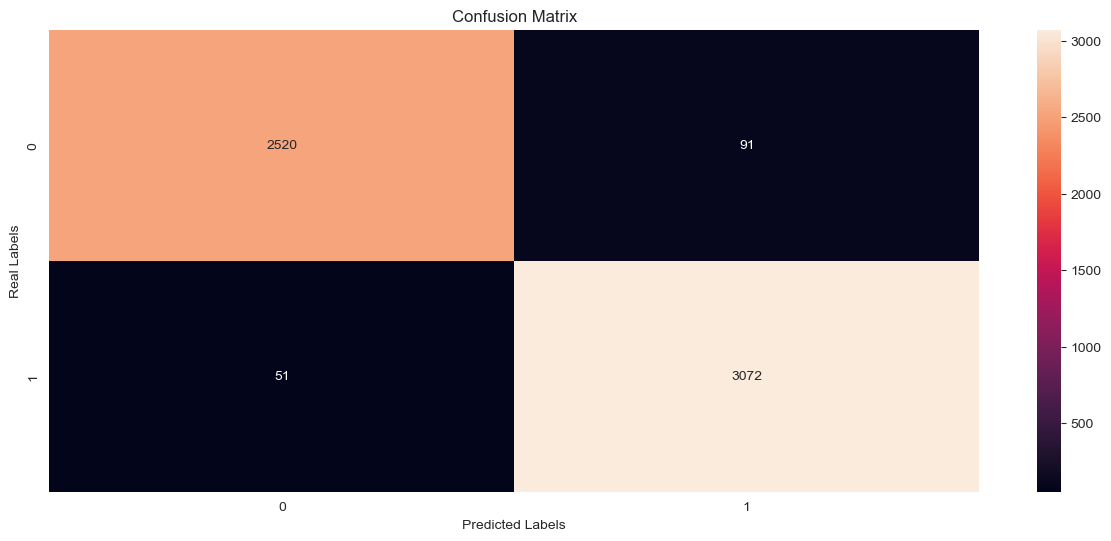

              precision    recall  f1-score   support

           0       0.99      0.96      0.97      2612
           1       0.97      0.99      0.98      3123

    accuracy                           0.98      5735
   macro avg       0.98      0.98      0.98      5735
weighted avg       0.98      0.98      0.98      5735



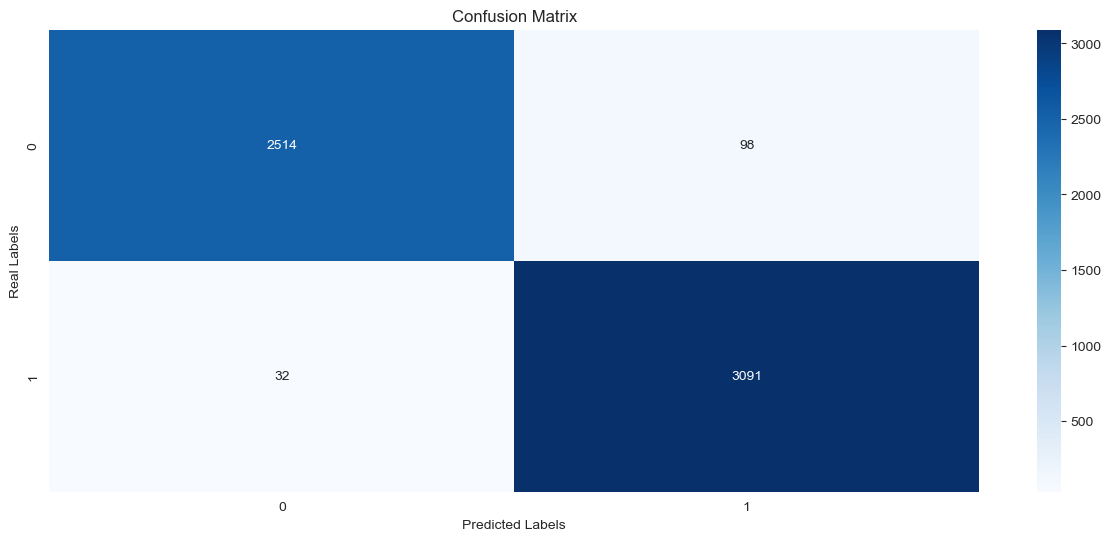

2025/01/13 12:02:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'sk-learn-logistic-regression' already exists. Creating a new version of this model...
2025/01/13 12:02:05 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: sk-learn-logistic-regression, version 5
Created version '5' of model 'sk-learn-logistic-regression'.


Experiment logged successfully!
🏃 View run Logistic Regression join text Experiment at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0/runs/5419208896c9414382d1c1689ee5fce8
🧪 View experiment at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0


AttributeError: 'NoneType' object has no attribute 'info'

In [43]:
preprocessor_4 = ColumnTransformer(
    transformers=[
        ("text", text_pipeline, "title_text_join")
    ]
)

model_pipeline = Pipeline([
    ("preprocessor", preprocessor_4),
    ("classifier", LogisticRegression())
])
model_pipeline.fit(X_train, y_train)

# predictions for validation
y_pred = model_pipeline.predict(X_val)
report = classification_report(y_val, y_pred, output_dict=True)
print(classification_report(y_val, y_pred))
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(15, 6))
sns.heatmap(cm, annot=True, fmt='')
plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')
plt.title('Confusion Matrix')
plt.show()

# predictions for test
y_pred_test = model_pipeline.predict(X_test)
report_test = classification_report(y_test, y_pred_test, output_dict=True)
print(classification_report(y_test, y_pred_test))
cm_test = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(15, 6))
sns.heatmap(cm_test, annot=True, fmt='', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')
plt.title('Confusion Matrix')
plt.show()

mlflow.set_experiment("Fake news comments")
with mlflow.start_run(run_name="Logistic Regression join text Experiment"):
    mlflow.log_param("model", "LogisticRegression joint text")
    mlflow.log_param("preprocessor", "Custom Preprocessor")
    mlflow.log_param("data_split", "Train/Validation/Test")
    mlflow.log_param("dataser_version", "clean dataset")

    # Log confusion matrix values
    for i, row in enumerate(cm):
        for j, value in enumerate(row):
            mlflow.log_metric(f"cm_{i}_{j}", value)
    for metric, value in report["weighted avg"].items():
        mlflow.log_metric(f"weighted_{metric}", value)
    mlflow.log_metric("accuracy", report["accuracy"])
    # Log overall metrics
    total_samples = len(y_val)
    correct_predictions = sum(cm[i][i] for i in range(len(cm)))  # Diagonal sum
    incorrect_predictions = total_samples - correct_predictions
    mlflow.log_metric("total_samples", total_samples)
    mlflow.log_metric("correct_predictions", correct_predictions)
    mlflow.log_metric("incorrect_predictions", incorrect_predictions)
    
        # Log confusion matrix values
    for i, row in enumerate(cm_test):
        for j, value in enumerate(row):
            mlflow.log_metric(f"cm_test_{i}_{j}", value)
    for metric, value in report_test["weighted avg"].items():
        mlflow.log_metric(f"weighted_test{metric}", value)
    mlflow.log_metric("accuracy_test", report_test["accuracy"])
    # Log overall metrics
    total_samples = len(y_test)
    correct_predictions = sum(cm_test[i][i] for i in range(len(cm_test)))  # Diagonal sum
    incorrect_predictions = total_samples - correct_predictions
    mlflow.log_metric("total_samples_test", total_samples)
    mlflow.log_metric("correct_predictions_test", correct_predictions)
    mlflow.log_metric("incorrect_predictions_test", incorrect_predictions)

    # Log the model to MLflow
    mlflow.sklearn.log_model(
        sk_model=model_pipeline,
        artifact_path="model_pipeline",
        registered_model_name="sk-learn-logistic-regression"  # Correct argument
    )
    print("Experiment logged successfully!")

# Register the model
model_uri = f"runs:/{mlflow.active_run().info.run_id}/model_pipeline"
result = mlflow.register_model(
    model_uri=model_uri,
    name="sk-learn-logistic-regression"
)

print(f"Model registered successfully! Name: {result.name}, Version: {result.version}")

In [44]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97      2612
           1       0.97      0.99      0.98      3123

    accuracy                           0.98      5735
   macro avg       0.98      0.98      0.98      5735
weighted avg       0.98      0.98      0.98      5735



We still see a good behaving of the results, so we will futher analyze whats happening with in the dataset

In [45]:
title = "Scientists Discover Alien Life on Mars"
text = "In a groundbreaking revelation, a team of international scientists announced today that they have discovered evidence of intelligent alien life on Mars. The discovery reportedly includes structures resembling ancient buildings, inscriptions in an unknown language, and traces of advanced technology buried beneath the Martian soil. According to Dr. Liza Carter, lead researcher at the Mars Exploration Institute, This finding will redefine humanity's understanding of the universe and our place within it. Social media is abuzz with theories, ranging from peaceful extraterrestrial civilizations to potential interplanetary conflicts. However, some experts caution that these claims lack solid evidence and may be part of an elaborate hoax. Stay tuned for further updates on this developing story!"

comment_example = pd.DataFrame({"title_text_join": [title + " " + text]})
# prediction = model_pipeline.predict(comment_example)
prediction = model_pipeline.predict(comment_example)
prediction

array([0], dtype=int64)

In [46]:
X_train.to_csv("dataset/X_train_cleaned.csv", index=False)
X_val.to_csv("dataset/X_val_cleaned.csv", index=False)
X_test.to_csv("dataset/X_test_cleaned.csv", index=False)

In [47]:
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

def count_words(text):
    words = word_tokenize(text.lower())  
    word_freq = FreqDist(words)
    return dict(word_freq)  

X_test_copy = X_test.copy()
X_test_copy["word_frequencies"] = X_test_copy["title_text_join"].apply(count_words)
print(X_test_copy[["title_text_join", "word_frequencies"]].head())

all_word_frequencies = FreqDist()
for word_freq in X_test_copy["word_frequencies"]:
    all_word_frequencies.update(word_freq)
most_common_words = all_word_frequencies.most_common(20)
most_common_words

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hanns\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\hanns\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


                                     title_text_join  \
0  suicide bomber kills nine near afghan politica...   
1  catalonia 's independence leader wages battle ...   
2  trump got caught something really creepy vacat...   
3  hezbollah leader says israeli war lebanon unli...   
4  teen wearing confederate flag shirt michigan s...   

                                    word_frequencies  
0  {'suicide': 3, 'bomber': 3, 'kills': 1, 'nine'...  
1  {'catalonia': 7, ''s': 1, 'independence': 16, ...  
2  {'trump': 9, 'got': 1, 'caught': 1, 'something...  
3  {'hezbollah': 2, 'leader': 2, 'says': 1, 'isra...  
4  {'teen': 1, 'wearing': 2, 'confederate': 5, 'f...  


[(',', 113188),
 ('.', 79116),
 ('trump', 19646),
 ('said', 17775),
 ('’', 11828),
 (':', 8987),
 ('”', 8336),
 ('“', 8315),
 ('would', 7298),
 ('u.s.', 7116),
 ('president', 7066),
 ('people', 5403),
 ('one', 4813),
 ('state', 4559),
 ('also', 3978),
 ('new', 3953),
 ('obama', 3752),
 ('donald', 3729),
 ('republican', 3701),
 ('house', 3671)]

We still see some values that were taked out, so now that we save the model baseline and the dataset we will explore it with LIME to see which values are giving us more predictibility for the last outcome.

We try to find several words that can impact the model, but nothing was found in this last review.

# Conclusions

At the end we see try different features, but seems to not add value to the final result, so probably its need it to make some adjustments but at the end we had the baseline model result for the "LogisticRegression"

In this case the model was performing really good, so now we can iterate with the Neural networks models to try to adjust them.



